In [1]:
import os 
import sys 
sys.path.append("../src")

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import seed, train

In [2]:
np.__version__ 

'1.19.1'

In [3]:
torch.__version__

'1.6.0'

In [4]:
class ExperimentOneTask:
    def __init__(self, weights, bias=None, input_range=None):
        self.in_features = weights.shape[1]
        self.weights = weights
        self.bias = bias
        self.input_range = input_range
        
    def sample(self, count: int) -> torch.Tensor:
        with torch.no_grad():
            xs = torch.randn(count, self.in_features).float()
            if self.input_range is not None:
                xs = torch.clamp(xs, *self.input_range)
            ys = F.linear(xs, self.weights, self.bias)
            return xs, ys

In [5]:
class ExperimentOneGenerator:
    def __init__(self, in_features, out_features, input_range: Tuple[int, int] = None, bias=True, mask_proba: float=0.5):
        self.in_features = in_features
        self.out_features = out_features
        self.input_range = input_range
        self.has_bias = bias
        self.mask_proba = mask_proba
        
        self.weights = np.random.uniform(size=(self.out_features, self.in_features))
        if self.has_bias:
            self.bias = np.random.uniform(size=(self.out_features,))
            
    def createTask(self):
        weight_mask = np.random.uniform(size=(self.out_features, self.in_features)) < self.mask_proba
        task_weights = torch.from_numpy(self.weights * weight_mask).float()
        
        if self.has_bias:
            bias_mask = np.random.uniform(size=(self.out_features, )) < self.mask_proba
            task_bias = torch.from_numpy(self.bias * bias_mask).float()
        else:
            task_bias = None
            
        return ExperimentOneTask(task_weights, task_bias, self.input_range)

# Plot the Data

In [6]:
gen1 = ExperimentOneGenerator(2, 1)
seed(1) 
task1 = gen1.createTask() # currently has second variable 'turned off'
task2 = gen1.createTask() # both variables on

In [7]:
train1x, train1y = task1.sample(50)
train2x, train2y = task2.sample(50)

In [8]:
task1.weights, task1.bias

(tensor([[0.7458, 0.0000]]), tensor([0.1993]))

In [9]:
task2.weights, task2.bias

(tensor([[0.7458, 0.7188]]), tensor([0.1993]))

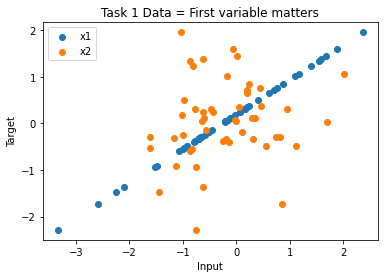

In [10]:
plt.title("Task 1 Data = First variable matters")
plt.scatter(train1x[:,0], train1y)
plt.scatter(train1x[:,1], train1y)
plt.xlabel("Input")
plt.ylabel("Target")
plt.legend(["x1", "x2"])

### One looks like complete noise, the other is perfect fit

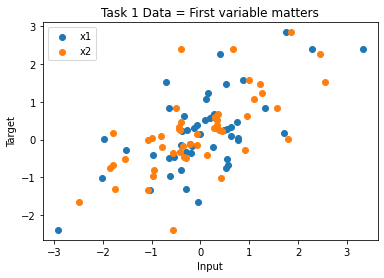

In [11]:
plt.title("Task 1 Data = First variable matters")
plt.scatter(train2x[:,0], train2y)
plt.scatter(train2x[:,1], train2y)
plt.xlabel("Input")
plt.ylabel("Target")
plt.legend(["x1", "x2"])

### Both are somewhat fits, but the variable that was previously stronger is no longer perfect fit

In [12]:
exp1 = ExperimentOneGenerator(5, 1, mask_proba=0.25)
tasks = [exp1.createTask() for _ in range(100)]
trainsets = [task.sample(50) for task in tasks]
testsets = [task.sample(50) for task in tasks]

In [13]:
make_model = lambda : GatedLinear(5, 1)
make_optim = lambda params: Adam(params, learning_rate=3e-4)
criterion = nn.MSELoss()

In [14]:
train(
    make_model=lambda : GatedLinear(5, 1),
    make_optim = lambda params: Adam(params, learning_rate=3e-4),
    tasks=trainsets, criterion=criterion, )

TypeError: 'int' object is not iterable